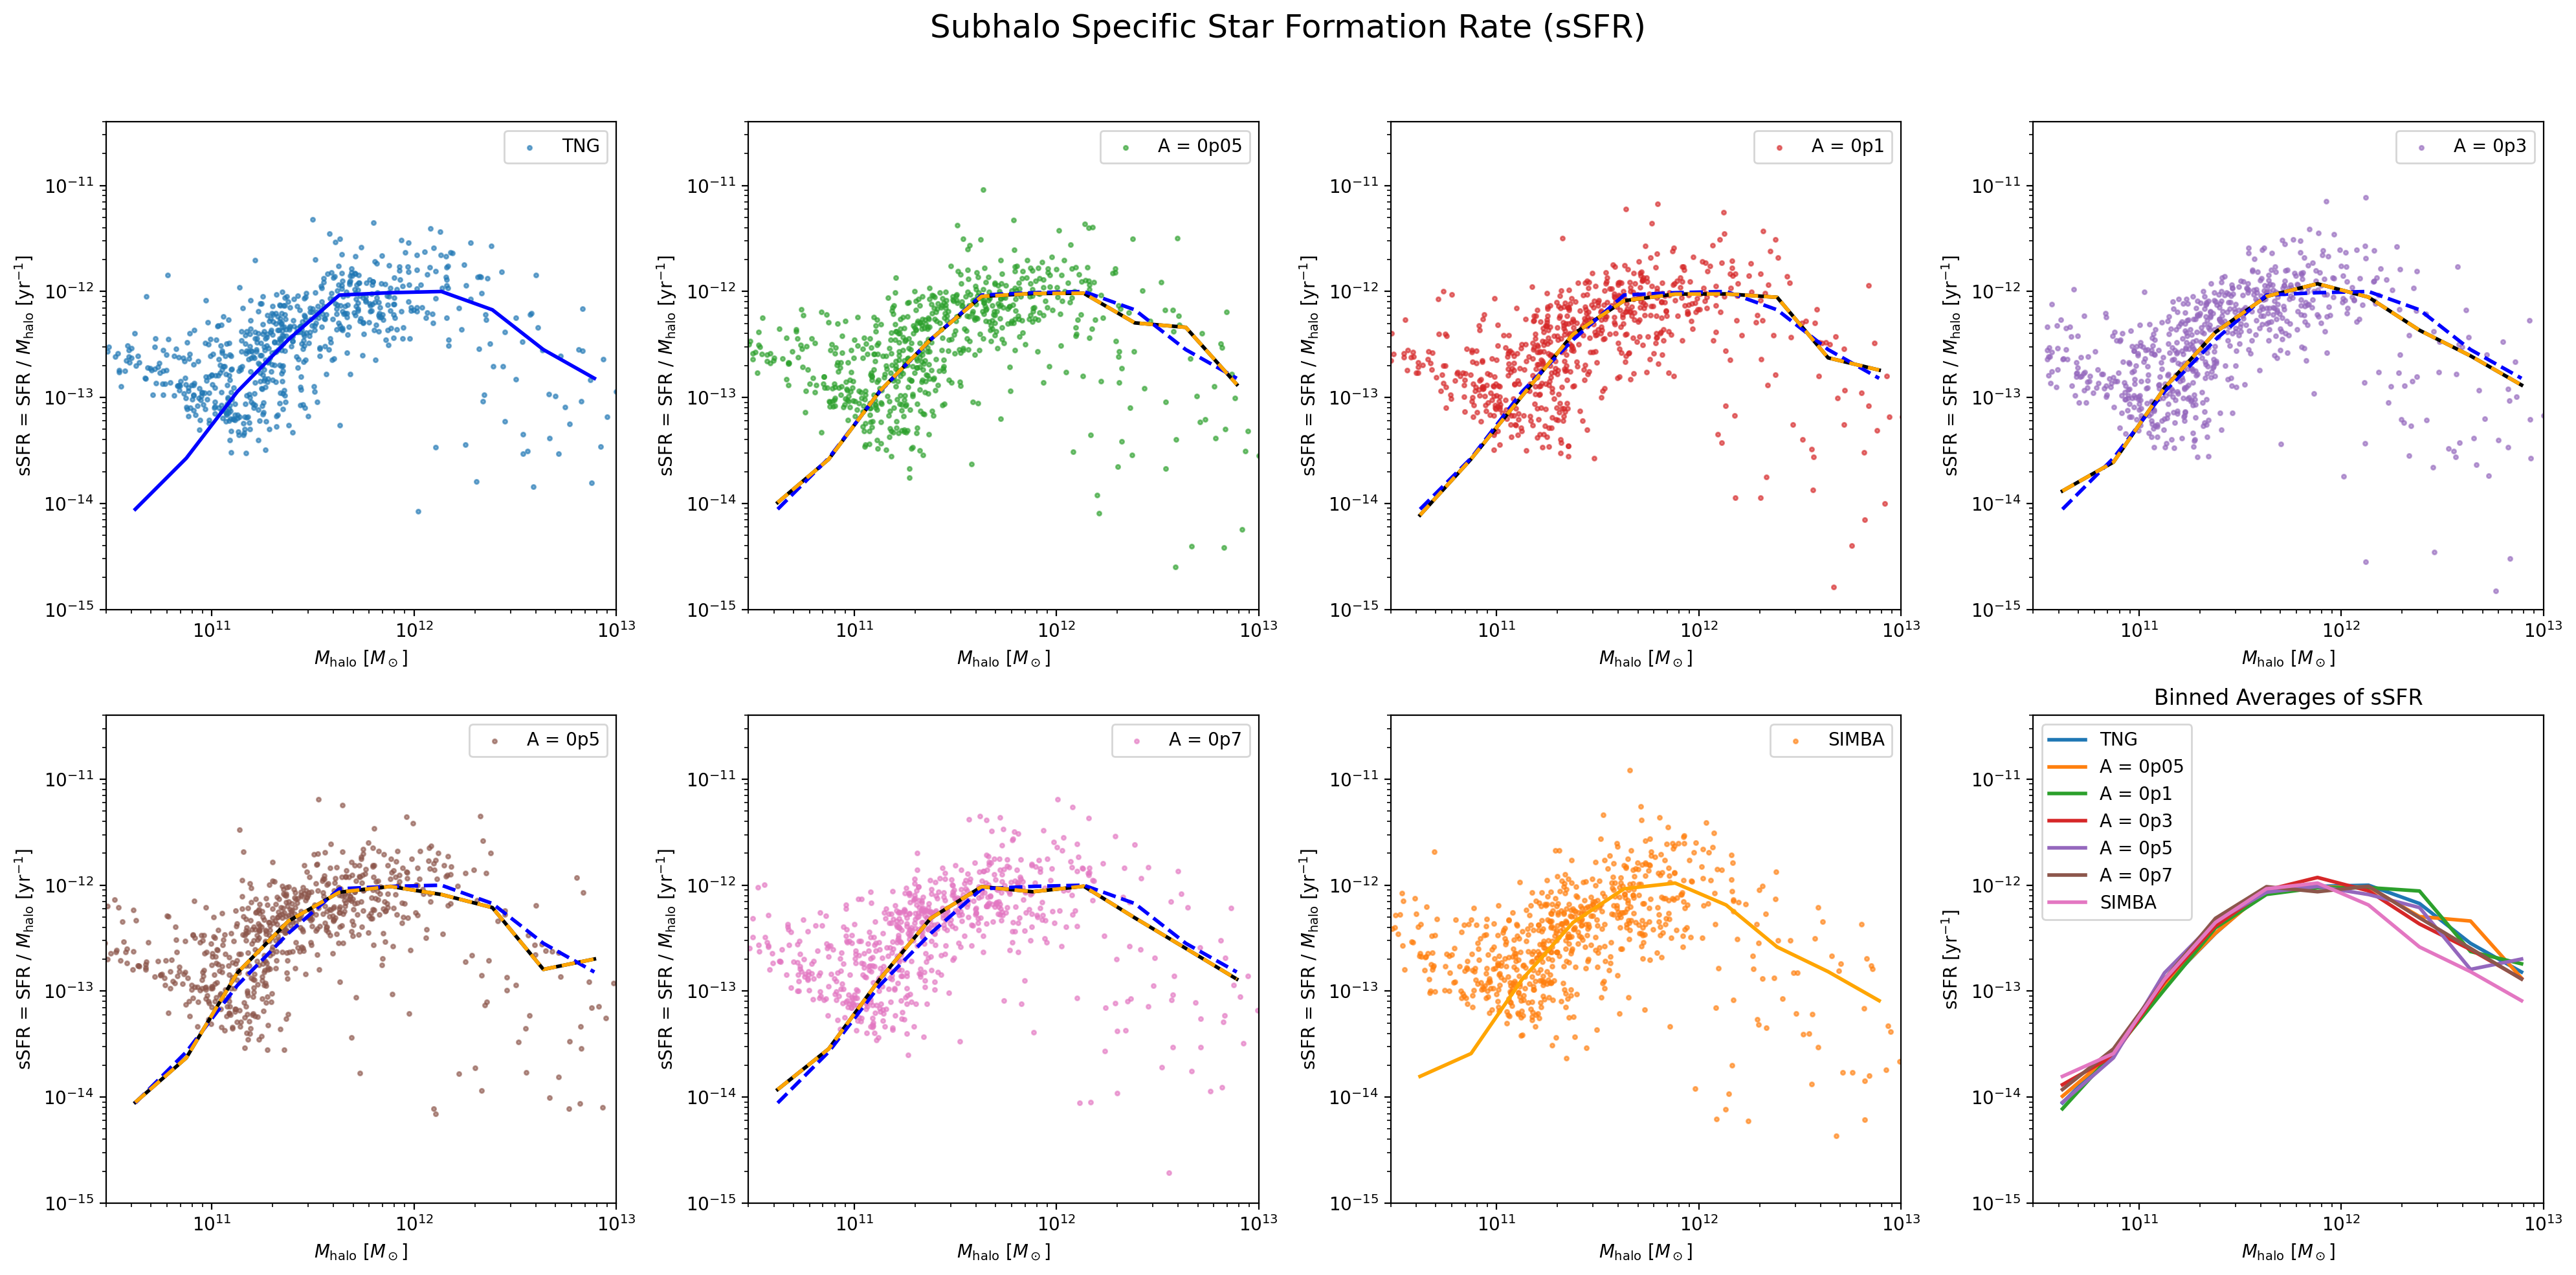

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

h = 0.6711
omega_b_over_omega_m = 0.16

def StarFormation_sSFR(file, fof, color, name, ax, avrgs, bin_edges):
    data = h5py.File(file, "r")
    f = h5py.File(fof, "r")

    Mstar_sub = f["Subhalo/SubhaloMassType"][:,4] * 1e10 / h
    SFR_sub = f["Subhalo/SubhaloSFR"][:]
    sub_to_halo = f["Subhalo/SubhaloGroupNr"][:]
    nhalo = f["Group/GroupMass"].shape[0]

    Mstar_halo = np.bincount(sub_to_halo, weights=Mstar_sub, minlength=nhalo)
    SFR_halo = np.bincount(sub_to_halo, weights=SFR_sub, minlength=nhalo)
    Mhalo = f["Group/GroupMass"][:] * 1e10 / h

    sSFR = SFR_halo / Mhalo  

    bin_sums, _ = np.histogram(Mhalo, bins=bin_edges, weights=sSFR)
    counts, _ = np.histogram(Mhalo, bins=bin_edges)
    bin_means = bin_sums / np.maximum(counts, 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    if name == "TNG":
        ax.plot(bin_centers, bin_means, color="blue", lw=2)
    elif name == "SIMBA":
        ax.plot(bin_centers, bin_means, color="orange", lw=2)
    else:
        ax.plot(bin_centers, bin_means, color="black", lw=2)

    avrgs.append((bin_centers, bin_means))

    if name not in ["TNG", "SIMBA"]:
        ax.plot(avrgs[0][0], avrgs[0][1], color="blue", linestyle='--', lw=2)
        ax.plot(avrgs[-1][0], avrgs[-1][1], color="orange", linestyle='--', lw=2)

    ax.scatter(Mhalo, sSFR, s=5, label=name, alpha=0.6, color=color)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(3e10, 1e13)
    ax.set_ylim(1e-15, 4e-11)
    ax.set_xlabel(r"$M_{\rm halo}\ [M_\odot]$")
    ax.set_ylabel(r"sSFR = SFR / $M_{\rm halo}$ [yr$^{-1}$]")
    ax.legend()

# Files
TNG = "data/Output-fidTNG_CAMELS/snap_032.hdf5"
runs = ["0p05","0p1","0p3","0p5","0p7"]
EOS_files = [f"SimbaTNG-production/d7202e7--EOS-{r}/snap_032.hdf5" for r in runs]
SIMBA = "SimbaTNG-production/d7202e7--EOS-1p0/snap_032.hdf5"

TNG_fof = "data/Output-fidTNG_CAMELS/fof_subhalo_tab_032.hdf5"
EOS_fof = [f"SimbaTNG-production/d7202e7--EOS-{r}/fof_subhalo_tab_032.hdf5" for r in runs]
SIMBA_fof = "SimbaTNG-production/d7202e7--EOS-1p0/fof_subhalo_tab_032.hdf5"

data = [TNG] + EOS_files + [SIMBA]
fof = [TNG_fof] + EOS_fof + [SIMBA_fof]
names = ["TNG"] + [f"A = {r}" for r in runs] + ["SIMBA"]
colors = ["tab:blue","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:orange"]

# Fixed bin edges
bin_edges = np.logspace(np.log10(3e10), 13, 11)

fig, axes = plt.subplots(2, 4, figsize=(20, 10), dpi=200)
axes = axes.flatten()
avrgs = []

# Plot: TNG -> EOS runs -> SIMBA
for i in range(len(data)):
    ax = axes[i] if i < 7 else axes[6]  # first 7 subplots
    StarFormation_sSFR(data[i], fof[i], colors[i], names[i], ax, avrgs, bin_edges)

# Last subplot: all averages
ax_avg = axes[7]
for i, (centers, means) in enumerate(avrgs):
    ax_avg.plot(centers, means, lw=2, label=names[i])
ax_avg.set_xscale('log')
ax_avg.set_yscale('log')
ax_avg.set_xlim(3e10, 1e13)
ax_avg.set_ylim(1e-15, 4e-11)
ax_avg.set_xlabel(r"$M_{\rm halo}\ [M_\odot]$")
ax_avg.set_ylabel(r"sSFR [yr$^{-1}$]")
ax_avg.set_title("Binned Averages of sSFR")
ax_avg.legend()

fig.suptitle("Subhalo Specific Star Formation Rate (sSFR)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()